## 한글 폰트를 설치합니다.
* 바른을 설치하기 전에 미리 아래의 한글 폰트 설치코드를 실행하고 상단 탭의 **런타임>런타임 다시 시작** 클릭합니다.
* 아래 시각화에서 한글이 제대로 나오지 않는다면 설치 후 런타임을 다시 시작해야하기 때문입니다.

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

## 바른 형태소 분석기 활용 3(단어 네트워크 그리기)
(이미 설치를 완료하신 분들은 아래 '샘플 텍스트 파일 다운로드' 부분부터 실행하면 됩니다.)

바른 설치
바른을 설치합니다.

바른의 리눅스 설치본을 다운로드 받습니다.

In [36]:
!curl -LJks -H "uname:$(uname -a)" https://bareun.ai/api/get -o bareun-linux.deb
!ls

bareun-linux.deb			     nohup.out	  sum_sentences.txt
libtensorflow-gpu-linux-x86_64-2.9.1.tar.gz  sample_data  wordnet.png


In [37]:
!uname -a

Linux b3199099f142 5.10.147+ #1 SMP Sat Dec 10 16:00:40 UTC 2022 x86_64 x86_64 x86_64 GNU/Linux


**바른**을 설치합니다.

In [38]:
!dpkg -i bareun-linux.deb

(Reading database ... 122563 files and directories currently installed.)
Preparing to unpack bareun-linux.deb ...
System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to connect to bus: Host is down
System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to connect to bus: Host is down
Removed /etc/systemd/system/multi-user.target.wants/bareun.service.
Unpacking bareun (2.0.3) over (2.0.3) ...
Setting up bareun (2.0.3) ...
System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to connect to bus: Host is down
System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to connect to bus: Host is down
Created symlink /etc/systemd/system/multi-user.target.wants/bareun.service → /etc/systemd/system/bareun.service.


아래는 바른 모델이 GPU를 사용하기 위해서 다운받는 tensorflow 라이브러리입니다.

상단의 메뉴탭의 "런타임 > 런타임 유형 변경 > 하드웨어 가속기 > GPU 선택 > 저장"을 설정하시면 모델의 추론 속도가 더 빨라집니다. 단, 무료버전의 경우 coloab의 일일 사용 제한을 초과하지 않아야 합니다.

기본적으로 CPU를 사용해도 작동합니다.

In [39]:
!curl -O https://storage.googleapis.com/tensorflow/libtensorflow/libtensorflow-gpu-linux-x86_64-2.9.1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  392M  100  392M    0     0   243M      0  0:00:01  0:00:01 --:--:--  243M


In [40]:
!tar -C /opt/bareun -xzf libtensorflow-gpu-linux-x86_64-2.9.1.tar.gz

## 환경 설정하기
아래 코드는 BAREUN_ROOT와 LD_LIBRARY_PATH를 설정하고, /opt/bareun/bin/bareun을 백그라운드로 실행하는 코드입니다.

In [41]:
%env BAREUN_ROOT="/opt/bareun"
%env LD_LIBRARY_PATH="/opt/bareun/lib"
!BAREUN_ROOT="/opt/bareun" LD_LIBRARY_PATH="/opt/bareun/lib" nohup /opt/bareun/bin/bareun&


env: BAREUN_ROOT="/opt/bareun"
env: LD_LIBRARY_PATH="/opt/bareun/lib"
nohup: appending output to 'nohup.out'


In [42]:
!ps -ef | grep bareun

root        3589       1 13 03:36 ?        00:04:48 /opt/bareun/bin/bareun
root       13134    4268  0 04:12 ?        00:00:00 /bin/bash -c ps -ef | grep bareun
root       13148   13134  0 04:12 ?        00:00:00 grep bareun


API키 발급 바른 홈페이지(https://bareun.ai/) 에 회원가입해서 API키를 받습니다.

API키 복사
발급 받은 API키를 -reg 인자 다음에 입력하여 등록합니다.

In [57]:
!BAREUN_ROOT="/opt/bareun" LD_LIBRARY_PATH="/opt/bareun/lib" /opt/bareun/bin/bareun -reg "YOUR-API-KEY"

Use config file: /opt/bareun/config/bareun.json

------
200 OK
This apikey is already registered.


## 바른 사용하기
**PIP 패키지 설치**


In [58]:
!pip install -U bareunpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
import sys
import bareunpy as brn
import google.protobuf.text_format as tf
API_KEY = "YOUR-API-KEY"
tagger = brn.Tagger(API_KEY, "localhost", 5656)

## 샘플 텍스트 파일 다운로드

* 2,000개의 문장으로 구성된 샘플 텍스트 파일입니다.
* Aihub 방송 콘텐츠 대본 요약 데이터의 일부를 추출했습니다.

In [ ]:
!pip install -U gdown

In [61]:
!gdown  https://drive.google.com/file/d/1PgbLoFGbb19YLw6cC6eiS2__HwjXg5Qv/view?usp=share_link -O sum_sentences.txt --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1PgbLoFGbb19YLw6cC6eiS2__HwjXg5Qv
To: /content/sum_sentences.txt
100% 303k/303k [00:00<00:00, 114MB/s]


In [ ]:
!pip install tqdm networkx matplotlib gensim

## 단어 네트워크 그리기

In [63]:
from tqdm import tqdm
from bareunpy import Tagger

import networkx as nx
from gensim.models import Word2Vec

import matplotlib.pyplot as plt


In [64]:
def preprocess_text(lines, tagger, verb=False):
    """ 
    불용어를 제거하기 위해 토큰화한다.
    :param lines: 문장 리스트
    :param verb: 용언(동사, 형용사) 포함 여부
    :return: 토큰화된 문장 리스트 
    """
    count_dict = {}
    tokenized_lines = []
    for line in tqdm(lines):
        tagged = tagger.tags([line])
        tokens = []
        # 명사만 추출
        for p in tagged.pos():
            if p[1] == 'NNG' or p[1] == 'NNP':
                tokens.append(p[0])
        if verb:
            verbs = tagged.verbs() # 용언 list
            if len(verbs) != 0:
                for v in verbs:
                    tokens.append(v)
        # 빈도 계산
        if len(tokens) != 0:
            for n in tokens:
                if n in count_dict:
                    count_dict[n] += 1
                else:
                    count_dict[n] = 1
        tokenized_lines.append(tokens)

    return tokenized_lines, count_dict

In [65]:
def train_word2vec_model(sentences):
    model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4, sg=0)
    print(model.wv.vectors.shape)
    return model

In [66]:
def visualize_word_network(model, words, topn=10):
    """
    word2vec를 사용하여 주어진 단어에 대한 단어 네트워크 시각화
    :param model: word2vec model
    :param words: list of words
    :param topn: number of similar words to visualize for each word
    """
    plt.figure(figsize=(40, 30))
    G = nx.Graph()

    # Add nodes to the graph
    for word in words:
        try:
            word_check = model.wv.most_similar(word, topn=topn)
            G.add_node(word)
            # Add edges to the graph
            for similar_word, similarity in model.wv.most_similar(word, topn=topn):
                if similar_word in words:
                    G.add_edge(word, similar_word, weight=similarity)
        except:
            continue

    pos = nx.spring_layout(G)
    edges = list(G.edges())
    weights = []
    for u, v in edges:
        weights.append(G[u][v]['weight'])

    nx.draw(G, pos, edgelist=edges, 
            edge_color='green', 
            with_labels=True, font_family='NanumBarunGothic',
            font_weight='bold',
            font_size=50)
    plt.show()
    plt.savefig('wordnet.png')

In [67]:
def word_filter(sort_dict, topn=50, filter=None):
    """
    불필요한 단어와 1음절 단어를 제거합니다.
    :param sort_dict: 정렬한 단어 사전
    :param topn: 상위 단어 개수
    :param filter: 불필요한 단어 리스트
    :return words: 추출 단어 리스트
    """
    words = []
    cnt = 0

    for d in sort_dict:
        if cnt >= topn:
            break
        else:
            if d[0] not in filter and len(d[0]) != 1:
                words.append(d[0])
                cnt += 1
    return words

In [68]:
def loading_text(path):
  texts = []
  with open(path, 'r', encoding='utf-8') as f:
      for line in f:
          texts.append(line.strip())
  return texts

In [69]:
texts = loading_text('sum_sentences.txt')
print(texts[:5])

['민생당은 민주 평화당하고 대안신당 등이 통합되어 구태정치 등을 타파하고 국민의 실생활을 살피는 정치를 표방한다.', '사모펀드 투자에 관해 정경심은 자기 돈을 동생이 투자했다고 주장하지만, 검찰은 그가 동생과 함께 투자했다고 본다.', '문재인 대통령이 이미선, 문형배 헌법재판관 후보를 임명하려고 하로 자유한국당은 광화문 장외집회를 예고했다.', '검찰개혁은 제도 개혁과 수사권, 기소권 분리가 핵심인 만큼 민주당의 검찰개혁 시즌 2는 정확한 방향으로 가고 있다.', '국민들은 정권에 대한 일말의 기대와 희망을 접은 분위기이지만 그렇다고 제1야당인 자유한국당을 지지하지도 않는다.']


### 1. 명사만 포함하여 단어 네트워크 그리기
* 아래 시각화에서 한글이 제대로 나오지 않는다면, 폰트를 설치후 런타임 다시 시작을 하고 코드를 재실행해야합니다.
* word_filter 함수의 topn 인자를 수정하여 출력할 단어의 개수를 정할 수 있습니다.
* 출력 결과에서 상대적으로 중요도가 낮은 단어들이 나온다면 FILTER_LIST에 추가합니다(의존명사, 수식어 등이 있을 수 있습니다.)

100%|██████████| 2000/2000 [01:07<00:00, 29.64it/s]


(883, 100)


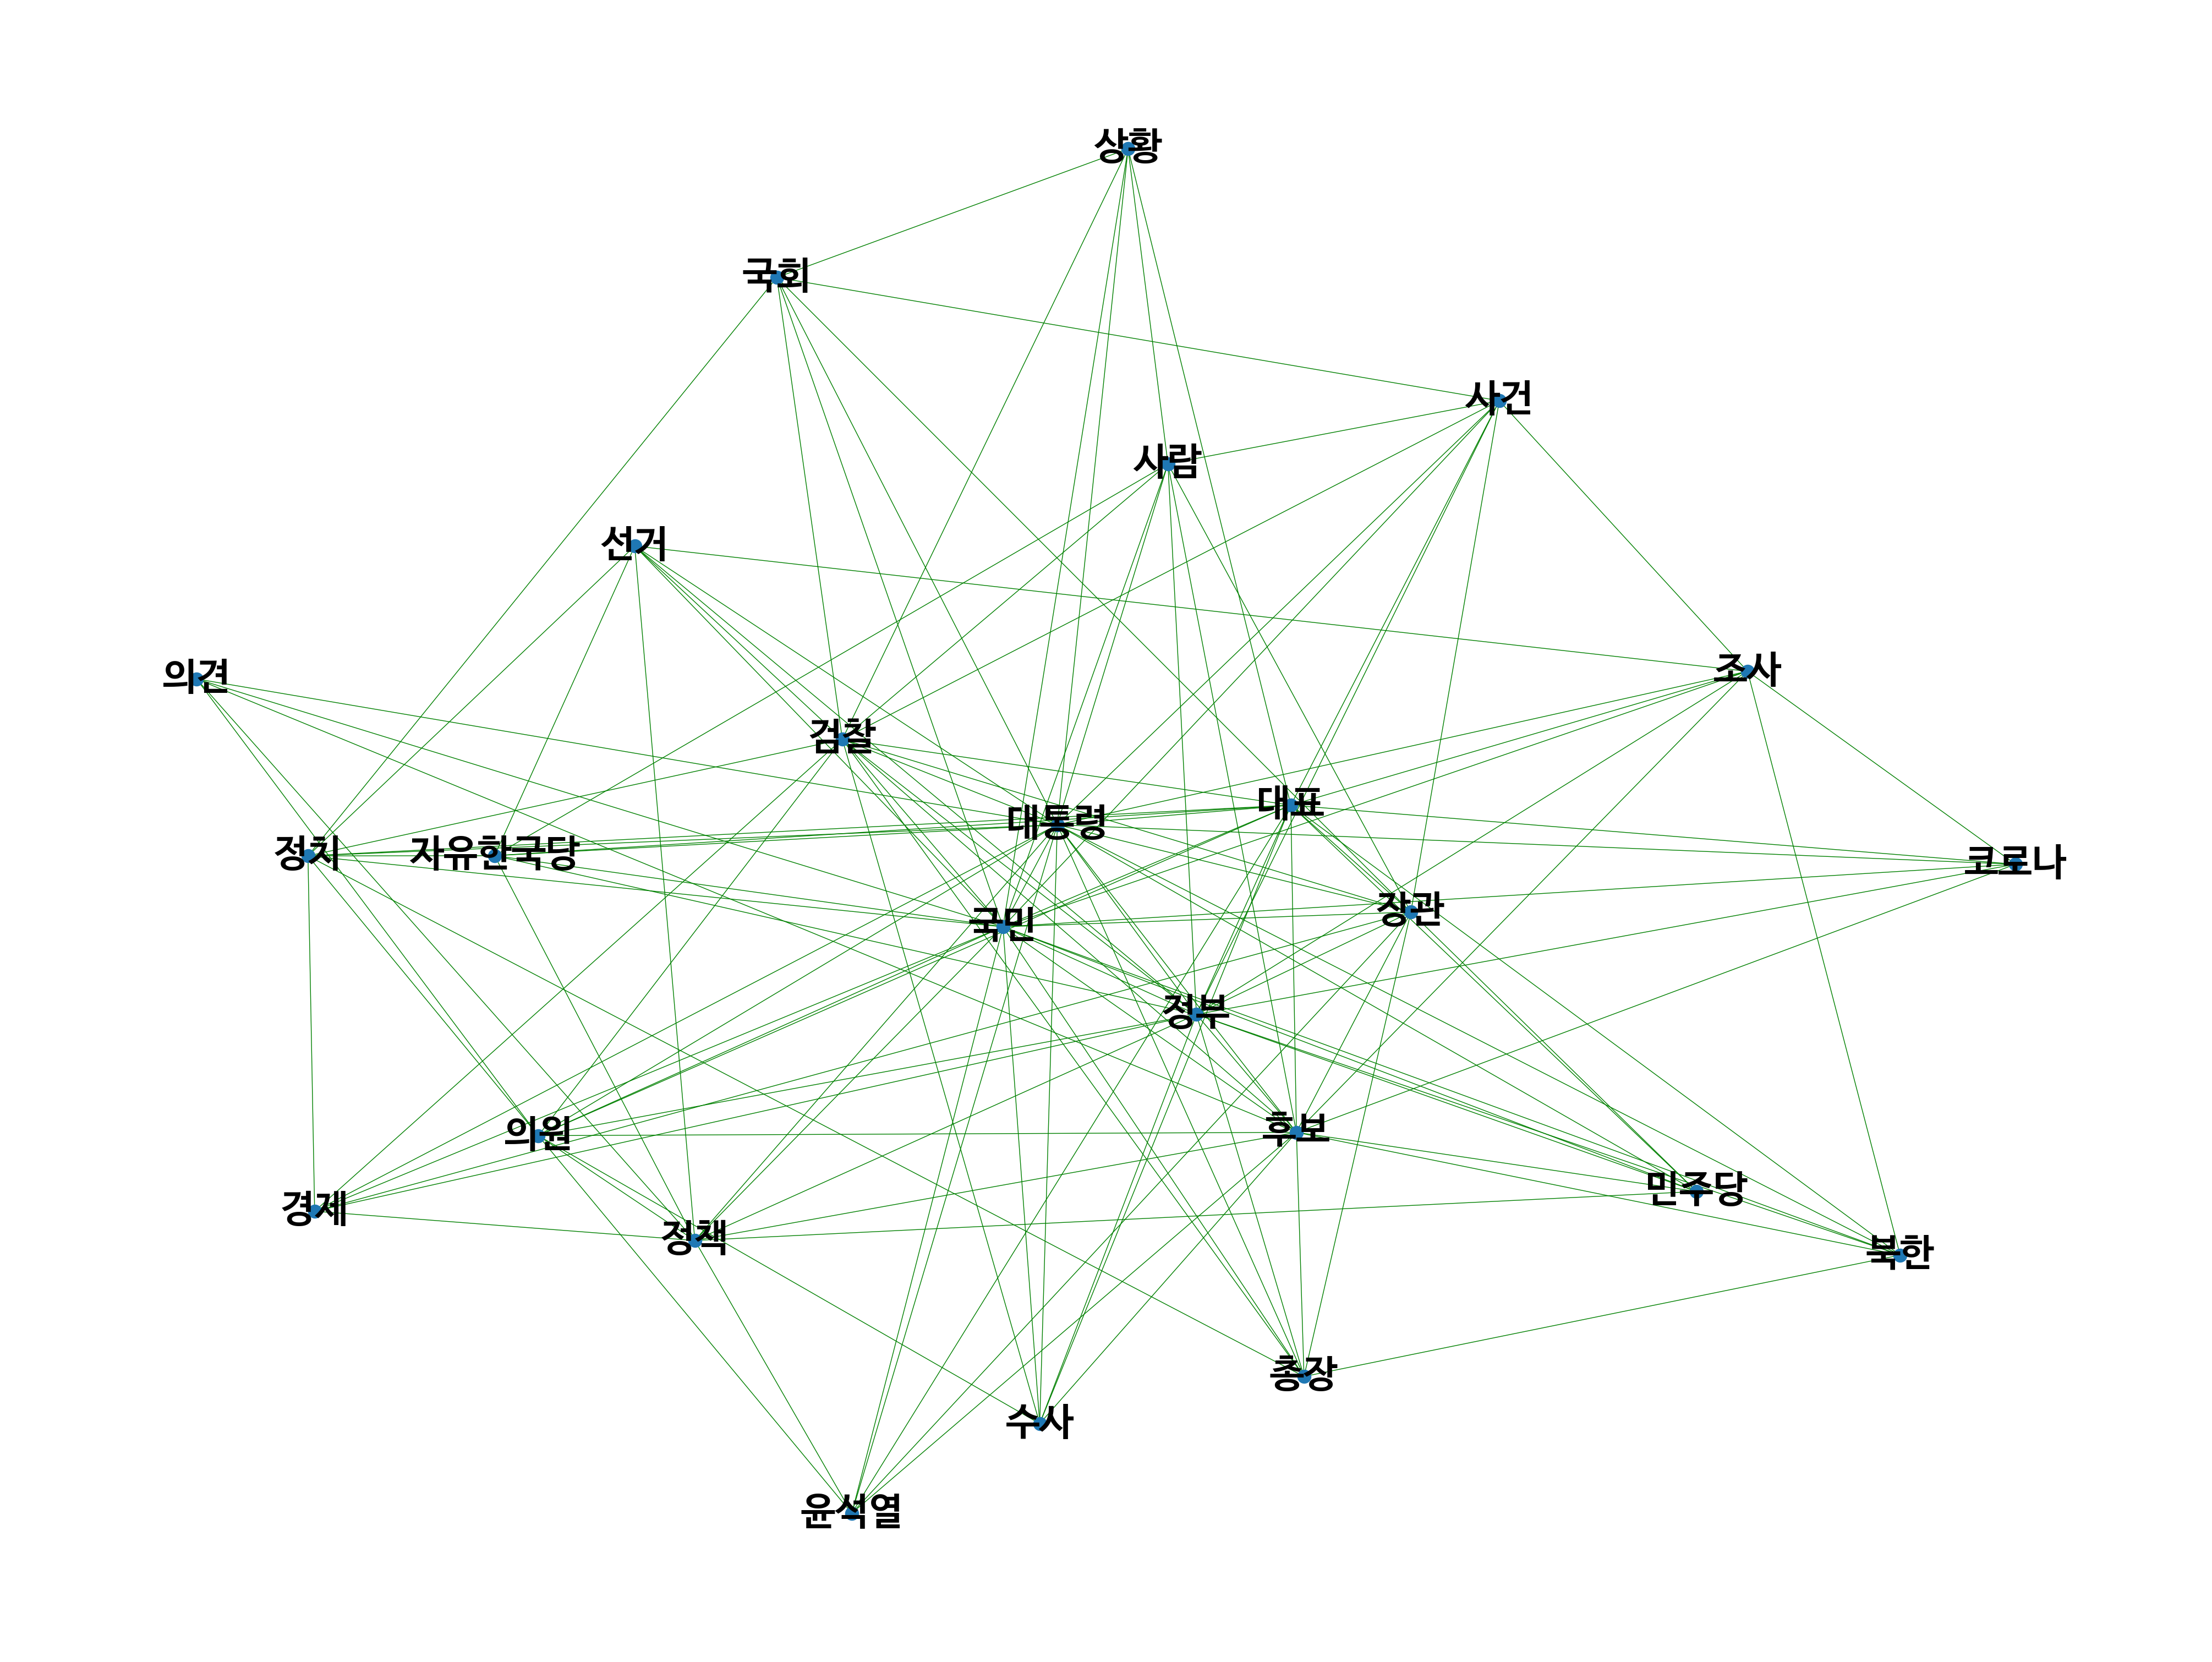

<Figure size 640x480 with 0 Axes>

In [70]:
# 문장 전처리
processed_texts, cnt_dict = preprocess_text(texts, tagger, verb=False)
# 단어를 내림차순으로 정렬
sort_dict = sorted(cnt_dict.items(), key=lambda x: x[1], reverse=True)
# word2vec 모델 훈련
word2vec_model = train_word2vec_model(processed_texts)
FILTER_LIST = ['경우', '문제', '관련', '필요', '위하', '대하']
# 상위 빈도 25개 단어 추출
words = word_filter(sort_dict, topn=25, filter=FILTER_LIST)
# 단어 네트워크 시각화
visualize_word_network(word2vec_model, words)

### 2. 동사, 형용사를 포함하여 단어 네트워크 그리기


100%|██████████| 2000/2000 [01:04<00:00, 30.96it/s]


(1115, 100)


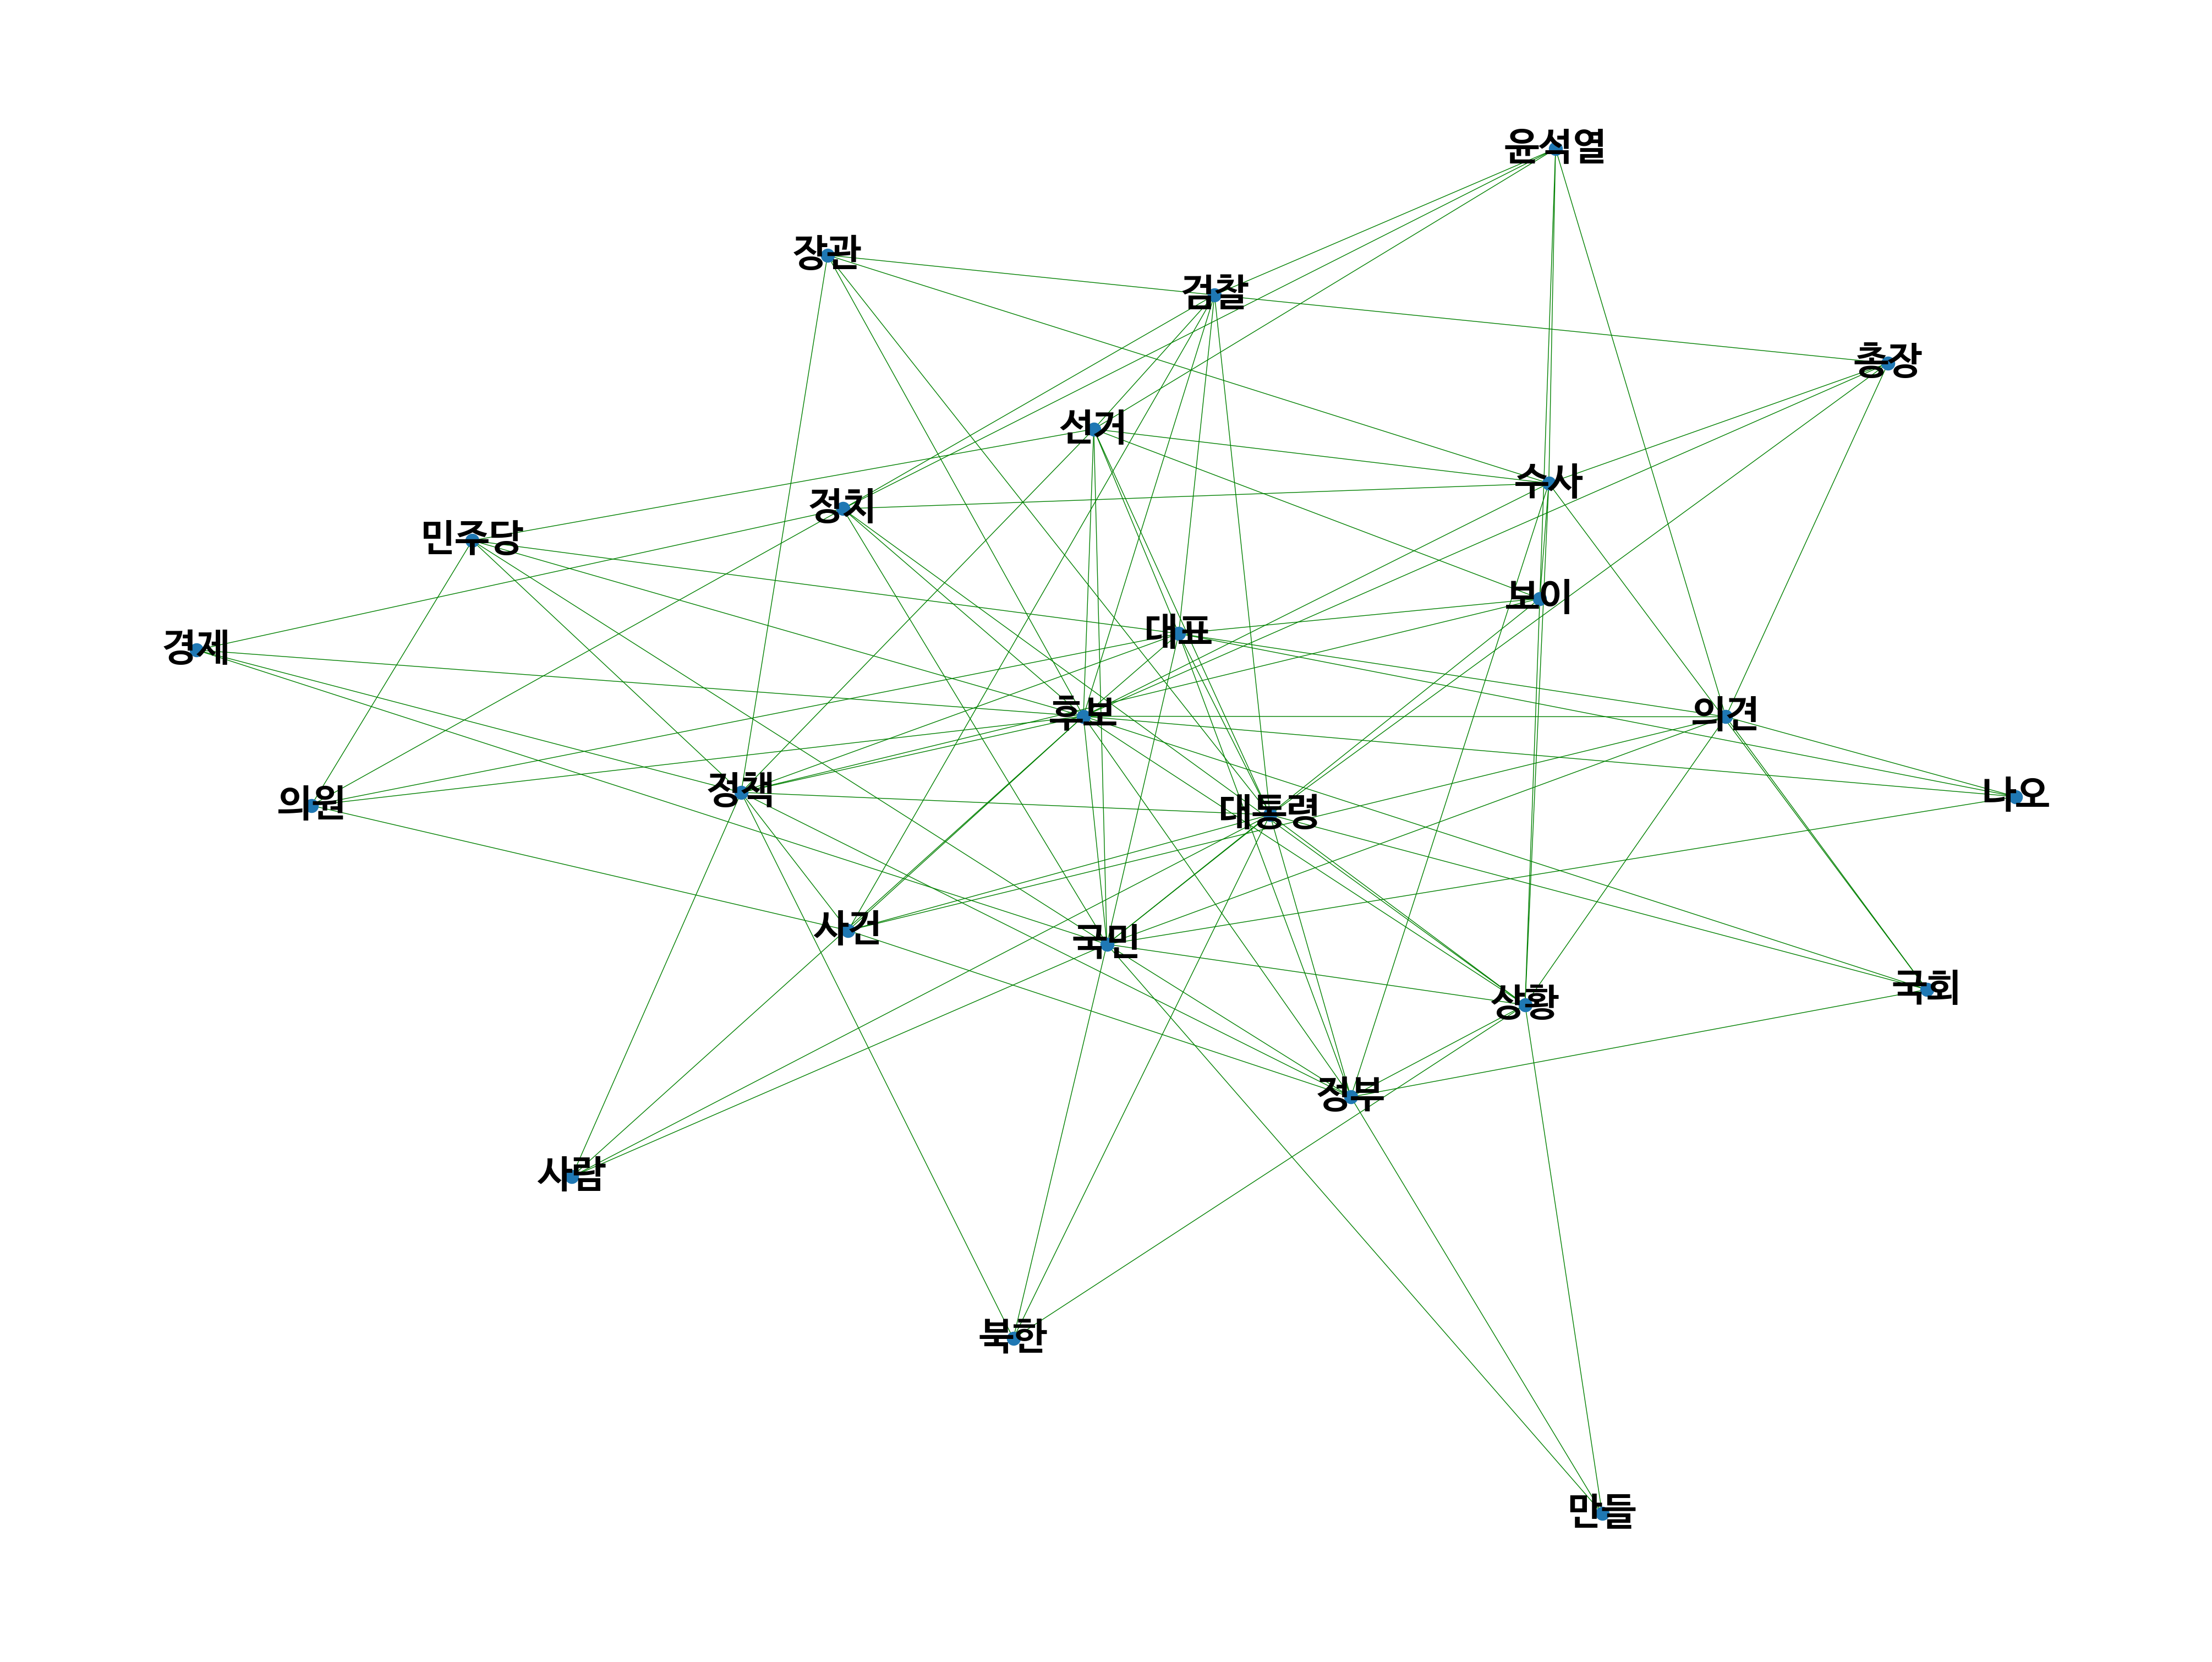

<Figure size 640x480 with 0 Axes>

In [71]:
# 문장 전처리
processed_texts, cnt_dict = preprocess_text(texts, tagger, verb=True)
# 단어를 내림차순으로 정렬
sort_dict = sorted(cnt_dict.items(), key=lambda x: x[1], reverse=True)
# word2vec 모델 훈련
word2vec_model = train_word2vec_model(processed_texts)
# 상위 빈도 25개 단어 추출
words = word_filter(sort_dict, topn=25, filter=FILTER_LIST)
# 단어 네트워크 시각화
visualize_word_network(word2vec_model, words)